In [1]:
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import torchvision.models as models

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.methods import SmoothGradCAMpp

from PIL import Image
from glob import glob

c:\Users\mai\anaconda3\envs\bmc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
class ResLayer(nn.Module):
    def __init__(self,sublabel_count,DEVICE):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(weights='IMAGENET1K_V1').to(DEVICE)
        self.num_ftrs = self.model.fc.out_features
        
        self.fc = nn.Sequential(
            #nn.BatchNorm1d(self.num_ftrs+self.n_mfcc),                
            nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,sublabel_count)
                            )

    def forward(self, x):
        x = self.model(x)
        x  = self.fc(x)
        return x

def model_initialize(sublabel_count,DEVICE):
    model = ResLayer(sublabel_count,DEVICE)
    model.load_state_dict(torch.load("../classification_sub/baseline_get_label_res18_512_segment_False.pt"))
    model.to(DEVICE).eval()
    return model

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_initialize(3, device)
images = glob('../data/bmc_label_voc/JPEGImages/*.jpg')

---
### inference

In [62]:
from torch.utils.data import Dataset, DataLoader
import cv2
import pandas as pd

In [86]:
class BowelDataset(Dataset):
    def __init__(self, data_path_list,label_df,to_tensor,transform,sublabel,multilabel):
        self.data_path_list = data_path_list
        self.label_df = label_df
        self.to_tensor = to_tensor
        self.transform = transform
        self.sublabel = sublabel #sublabel : color,residue,turbidity,label
        self.multilabel = multilabel # True or False

    def __len__(self):
        return len(self.data_path_list)

    def __getitem__(self, idx):
        file_path = self.data_path_list[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=self.to_tensor(image)
        
        if self.transform:
            #1. 이미지 사이즈 변환
            image=self.transform(image).type(torch.float32)# 이미지 0~1 정규화

        if self.multilabel:
            return image, torch.tensor(self.label_df.iloc[idx][self.sublabel]), torch.tensor(self.label_df.iloc[idx][['color','residue','turbidity']]) 


        return image, torch.tensor(self.label_df.iloc[idx][self.sublabel]), file_path

In [87]:

def load_dataloader(X,Y_df,sublabel,BATCH_SIZE,multilabel):
    loader = torch.utils.data.DataLoader(dataset = 
                                            BowelDataset(X,
                                                        Y_df,
                                                        to_tensor = transforms.ToTensor(),
                                                        transform = torch.nn.Sequential(
                                                                transforms.Resize([512,512]),
                                                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                            ),
                                                        sublabel=sublabel, # color,residue,turbidity, label 중 어느것을 맞추려는지 입력.
                                                        multilabel=multilabel,
                                                        ),
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            num_workers=0
                                            ) # 순서가 암기되는것을 막기위해.

    return loader

In [88]:
def get_num(file_str):
    return int(file_str.split("\\")[-1].split(".")[0])

In [89]:
filename = list(map(get_num,images))

In [90]:
#첫번째 열 이름 바꿔주기
label_df = pd.read_csv('../bmc.csv')
column_names = list(label_df.columns)
column_names[0] = 'file_name'
label_df.columns = column_names

# # Y값 찾아오기
all_data = pd.merge(pd.DataFrame(filename, columns=['file_name']),label_df,left_on='file_name',right_on='file_name',how='inner')

In [91]:
test_loader = load_dataloader(images,all_data,"label",1,False)

In [92]:
criterion = nn.CrossEntropyLoss()
def test_evaluate(model,test_loader,criterion,DEVICE):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.

    file_list = []
    with torch.no_grad():
        for image,label,file_path in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            file_list += file_path
            
        return predictions,answers,test_loss,file_list

In [93]:
# 3m 30s
predictions,answers,_,file_list=test_evaluate(model,test_loader,criterion,device)

In [126]:
wrong_answer = []
for i in range(len(predictions)):
    if predictions[i].cpu().numpy()[0] != answers[i].cpu().numpy():
        wrong_answer.append(file_list[i])

In [134]:
to_csv = pd.DataFrame({"files":wrong_answer})
to_csv.to_csv("./wrong.csv")

---
### GradCAM

In [137]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
import os

In [ ]:
os.makedirs("./gradcam")

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

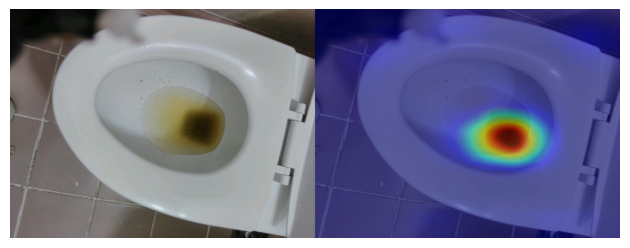

In [156]:
cam_extractor = SmoothGradCAMpp(model,target_layer="model.layer4")
# Get your input

for idx, path in enumerate(wrong_answer):
    img = read_image(path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (512, 512)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Preprocess your data and feed it to the model
    out = model(input_tensor.unsqueeze(0).to(device))
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
    result = get_concat_h(to_pil_image(img), result)

    # Display it & save
    plt.imshow(result); plt.axis('off'); plt.tight_layout(); #plt.show()
    plt.savefig('./gradcam/%04d.png'%(idx))
